# Direct Stream Digital sigma-delta modulator

A simulation and performance evaluation model of a modulator proposed by Nishio Ayataka at the 110th AES Convention in May 2001. Paper Number: 5392.

In [188]:
import numpy as np
import matplotlib.pyplot as plt

Set simulation parameters and generate test tone.

In [189]:
N = 2 ** 18
n = np.arange(N)
f_s = 64 * 44.1e3
f = 1000
a = 0.5
x = a * np.sin(2 * np.pi * n * f / f_s)

Set coefficients and allocate bufffers.

In [190]:
b = [ 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16 ]
c = [ -1 / 256, -1 / 256 ]
y = np.zeros(N)
z = np.zeros((2, 6))

Execute the model.

In [191]:
for n in range(N):
    y[n] = 1.0 if b[0] * (z[0, 1] + b[1] * z[0, 2] - z[0, 0]) > 0 else -1.0
    z[1, 0] = y[n]
    z[1, 1] = z[0, 1] + b[1] * z[0, 2] - z[0, 0]
    z[1, 2] = z[0, 2] + b[2] * z[0, 3] + c[0] * z[0, 1] - y[n]
    z[1, 3] = z[0, 3] + b[3] * z[0, 4] - y[n]
    z[1, 4] = z[0, 4] + b[4] * z[0, 5] + c[1] * z[0, 3] - y[n]
    z[1, 5] = z[0, 5] + x[n] - y[n]
    z[0, :] = z[1, :]

Window output, take FFT, and plot spectrum.

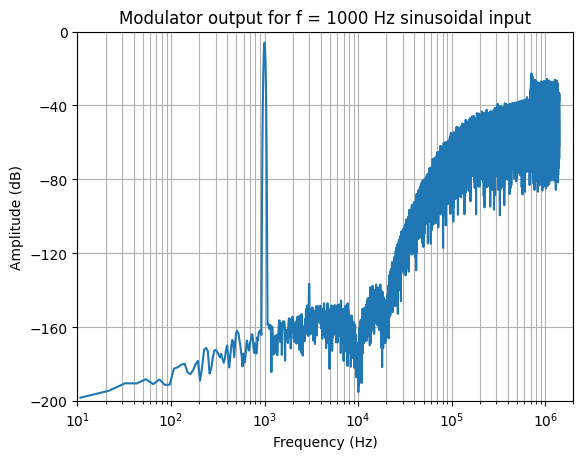

In [192]:
w = np.kaiser(N, 20)
k = 1 / np.mean(w)
Y = 2 * np.abs(np.fft.rfft(y * k * w)) / N
fig, axs = plt.subplots()
axs.semilogx(np.linspace(f_s / N, f_s / 2, N // 2), 20 * np.log10(np.abs(Y[1:])))
axs.set_xlim((10, 2e6))
axs.set_ylim((-200, 0))
axs.set_yticks(np.arange(-200, 1, 40))
axs.xaxis.grid(True, 'both')
axs.yaxis.grid(True)
axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel('Amplitude (dB)')
axs.set_title(f'Modulator output for f = {f} Hz sinusoidal input');

Measure 1/3 octave bandwidth signal and audio band THD+N.

In [193]:
f_lo, f_up = 2 ** (-1 / 6) * f, 2 ** (1 / 6) * f
bin_lo, bin_up = int(N * f_lo / f_s), int(N * f_up / f_s)
sig = np.sum(np.square(Y[bin_lo:bin_up]))

f_min, f_max = 22, 22e3
bin_min, bin_max = int(N * f_min / f_s), int(N * f_max / f_s)
thdn = np.sum(np.square(np.concatenate((Y[bin_min:bin_lo], Y[bin_up:bin_max]))))

snr = 10 * np.log10(sig / thdn)
print(f'Signal to noise and distortion ratio = {snr:.1f} dB')

Signal to noise and distortion ratio = 112.7 dB
